## IMPORT LIBRARES AND PACKAGES

In [28]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2

from PIL import Image
from scipy import stats

from keras.utils import to_categorical

## [1] DATA PREPARATION

Setup data directory

In [29]:
IMAGE_DIRECTORY = "./data-1/cohn-kanade-images/"
DATA_LABEL_DIRECTORY = "./data-1/data_labels.csv"

#### Load Label Dataset

In [30]:
df = pd.read_csv(DATA_LABEL_DIRECTORY)

Explore head

In [31]:
df.head(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,AU4,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
0,S005,1,11,./cohn-kanade-images/S005/001/S005_001_0000001...,S005_001_00000011,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
1,S010,1,14,./cohn-kanade-images/S010/001/S010_001_0000001...,S010_001_00000014,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,negative
2,S010,2,14,./cohn-kanade-images/S010/002/S010_002_0000001...,S010_002_00000014,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,surprise
3,S010,3,18,./cohn-kanade-images/S010/003/S010_003_0000001...,S010_003_00000018,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,negative
4,S010,4,19,./cohn-kanade-images/S010/004/S010_004_0000001...,S010_004_00000019,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,negative


Explore Tail

In [32]:
df.tail(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,AU4,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
555,S506,4,38,./cohn-kanade-images/S506/004/S506_004_0000003...,S506_004_00000038,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,negative
556,S506,6,42,./cohn-kanade-images/S506/006/S506_006_0000004...,S506_006_00000042,1,1,1,0,0,1,0,0,0,0,0,1,0,0,1,negative
557,S895,2,7,./cohn-kanade-images/S895/002/S895_002_0000000...,S895_002_00000007,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,negative
558,S999,1,18,./cohn-kanade-images/S999/001/S999_001_0000001...,S999_001_00000018,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,negative
559,S999,3,55,./cohn-kanade-images/S999/003/S999_003_0000005...,S999_003_00000055,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,negative


#### 1.1 DATA INTEGRITY CHECKING

Check Duplicate

In [33]:
print('Number of duplicated rows:', df.duplicated().sum())

Number of duplicated rows: 0


Check Nan Value

In [34]:
print('Number of Nan value rows:\n', df.isnull().sum())

Number of Nan value rows:
 subject               0
sequence              0
image_index           0
filepath              0
file_prefix           0
AU17                  0
AU1                   0
AU2                   0
AU25                  0
AU27                  0
AU4                   0
AU7                   0
AU23                  0
AU24                  0
AU6                   0
AU12                  0
AU15                  0
AU14                  0
AU11                  0
AU26                  0
high_level_emotion    0
dtype: int64


Check Data Overall 

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject             560 non-null    object
 1   sequence            560 non-null    int64 
 2   image_index         560 non-null    int64 
 3   filepath            560 non-null    object
 4   file_prefix         560 non-null    object
 5   AU17                560 non-null    int64 
 6   AU1                 560 non-null    int64 
 7   AU2                 560 non-null    int64 
 8   AU25                560 non-null    int64 
 9   AU27                560 non-null    int64 
 10  AU4                 560 non-null    int64 
 11  AU7                 560 non-null    int64 
 12  AU23                560 non-null    int64 
 13  AU24                560 non-null    int64 
 14  AU6                 560 non-null    int64 
 15  AU12                560 non-null    int64 
 16  AU15                560 no

## [2] EXPLORATORY DATA ANALYSIS

2.1 Check Label Count

/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_54009/2055809110.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls',)


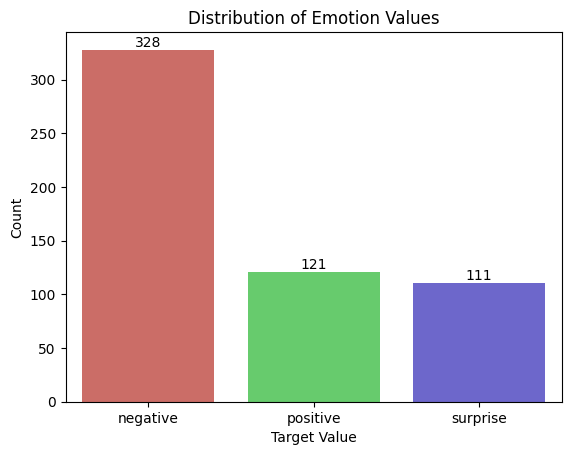

In [36]:
# Get the counts of each target value
target_value_counts = df['high_level_emotion'].value_counts()

# Create a bar plot
ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls',)

# Show the number of observations inside each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of Emotion Values')
plt.show()

**Observation**

It seems there are unbalanced count of negative comparing to other label

2.2 Visual Inspectation

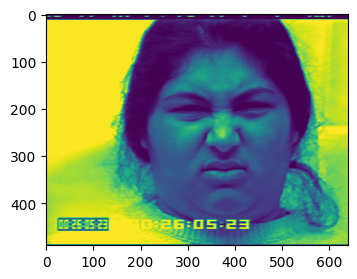

In [37]:
# For simplicity, let's just take the first subject and its first sequence
subject_sequence = df[(df['subject'] == 'S005') & (df['sequence'] == 1)]
sequence_files = subject_sequence['filepath'].tolist()

# Ensure that axes is always iterable
fig, axes = plt.subplots(1, len(sequence_files), figsize=(15, 3))
if len(sequence_files) == 1:
    axes = [axes]  # Make it a list so it's iterable

for ax, file in zip(axes, sequence_files):
    # Correct the file path by stripping the redundant part
    corrected_file_path = file.replace('./cohn-kanade-images/', '')
    img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('on')
    except IOError:
        print(f"Error opening image: {img_path}")

plt.show()

In [38]:
# Define an empty list to hold image sizes
image_sizes = []

# Define lists to hold mean and standard deviation of pixel values
mean_pixel_values = []
std_pixel_values = []

# Define a list to hold paths of corrupt images
corrupt_images = []

img_path_list = []
# Loop through the file paths in your DataFrame
for file_path in df['filepath']:
    corrected_file_path = file_path.replace('./cohn-kanade-images/', '')
    img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
    img_path_list.append(img_path)
    try:
        # Open the image and convert it to RGB (in case some are grayscale)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Check if the image is read correctly
        if img is not None:
            # Append the image size
            image_sizes.append(img.shape)
            
            # Calculate and store the mean and standard deviation of pixel values
            mean_pixel_values.append(np.mean(img))
            std_pixel_values.append(np.std(img))
        else:
            # If img is None, the image is corrupt
            corrupt_images.append(img_path)
            
    except Exception as e:
        # If an exception is raised, the image is likely corrupt
        corrupt_images.append(img_path)

In [39]:
# Now let's analyze the image sizes
image_sizes = np.array(image_sizes)
unique_sizes = np.unique(image_sizes, axis=0)

# We can print out or plot the unique sizes to decide on a common size
print(f"Unique image sizes: {unique_sizes}")

Unique image sizes: [[480 640   3]
 [480 720   3]
 [490 640   3]]


In [40]:
# Calculate the overall mean and standard deviation for the pixel values
overall_mean = np.mean(mean_pixel_values)
overall_std = np.std(std_pixel_values)

print(f"Overall mean pixel value: {overall_mean}")
print(f"Overall standard deviation of pixel values: {overall_std}")

# Print out corrupt images, if any
if corrupt_images:
    print("Found corrupt images:")
    for corrupt_img in corrupt_images:
        print(corrupt_img)
else:
    print("No corrupt images found.")

Overall mean pixel value: 99.93890188972647
Overall standard deviation of pixel values: 9.063075756547514
No corrupt images found.


In [41]:
# Background Consistency Check
background_modes = []

for img_path in img_path_list:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale simplifies the analysis
    border_pixels = np.concatenate([img[0, :], img[-1, :], img[:, 0], img[:, -1]])  # Extract border pixels
    mode = stats.mode(border_pixels)  # Find the mode of the border pixels
    background_modes.append(mode)

# Now you can analyze the background_modes list to check for consistency

/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_54009/63240558.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(border_pixels)  # Find the mode of the border pixels


Mean mode value: 11.378571428571428
Standard deviation of mode values: 47.69470887951871


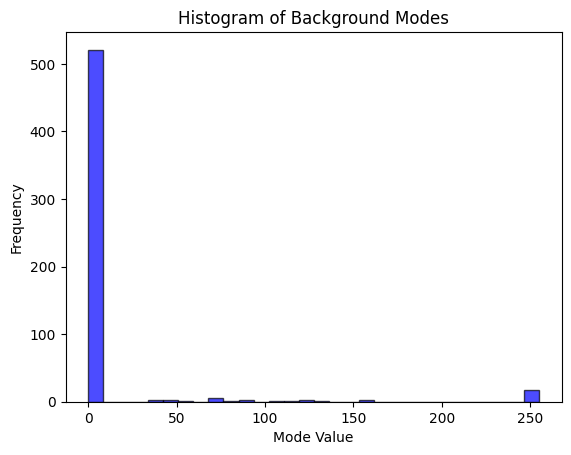

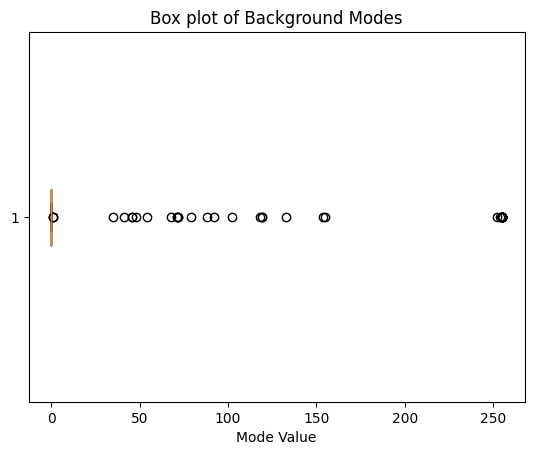

In [42]:

# Extract the mode values and counts
mode_values = [mode.mode[0] for mode in background_modes]
mode_counts = [mode.count[0] for mode in background_modes]

# Calculate basic statistics
mean_mode = np.mean(mode_values)
std_dev_mode = np.std(mode_values)

print(f"Mean mode value: {mean_mode}")
print(f"Standard deviation of mode values: {std_dev_mode}")

# Visualize the distribution of mode values
plt.hist(mode_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Background Modes')
plt.xlabel('Mode Value')
plt.ylabel('Frequency')
plt.show()

# Box plot for detecting outliers
plt.boxplot(mode_values, vert=False)
plt.title('Box plot of Background Modes')
plt.xlabel('Mode Value')
plt.show()

## [3] SETUP AND EXTRACT ESSENTIAL DATA 

#### 3.1 Load and Prepare Image Dataset

In [43]:
# Initialize an empty list to store processed images
img_data_list = []

# Get a list of image file paths from the 'filepath' column in the DataFrame
img_file_list = df['filepath'].tolist()

# Iterate through each image file path
for img in img_file_list:
    corrected_file_path = img.replace('./cohn-kanade-images/', '')
    img_path = os.path.join(IMAGE_DIRECTORY, corrected_file_path)
    input_img = cv2.imread(img_path)

    ### GrayScale ?
    grayscaled_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

    # Resize the image to a fixed size of 48x48 pixels
    input_img_resize=cv2.resize(grayscaled_image,(48,48))

    # Normalize the image pixel values to lie between 0 and 1
    normalized_image = input_img_resize / 255.0

    ### Expanded ? 
    expanded_image = np.expand_dims(normalized_image, axis=-1)

    img_data_list.append(expanded_image)

# Convert the list of resized images to a NumPy array
img_data = np.array(img_data_list)
# Convert the data type of pixel values to 'float32'
img_data = img_data.astype('float32')

# Check Shape
# 560 images.
# 48 pixels in height.
# 48 pixels in width.
# 1 since the image are grayscaled.
img_data.shape

(560, 48, 48, 1)

#### 3.2 Load and Prepare Label

In [44]:
# Define mapping conversion
target_mapping = {'negative': 0, 'positive': 1, 'surprise': 2}
df['high_level_emotion_num'] = df['high_level_emotion'].map(target_mapping)
labels = df['high_level_emotion_num'].to_list()
num_classes = 3
emotions_label = to_categorical(labels, num_classes=num_classes)

#### 3.3 Load and Prepare FACS CODE

In [45]:
facs_code_list = []
facs_code_df = df[df.columns[5:20]]
for i in range(df.shape[0]):
    facs_code_row = df.iloc[i, 5:20].tolist()
    facs_code_list.append(facs_code_row)
facs_list = np.array(facs_code_list)
facs_code_df

,AU17,AU1,AU2,AU25,AU27,AU4,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0
556,1,1,1,0,0,1,0,0,0,0,0,1,0,0,1
557,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
558,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0


## [4] TRAIN TEST SPLIT

In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

MIGHT RESAMPLE

SPLIT TRAIN, VAL, TEST SET

In [47]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train_facs, y_temp_facs, y_train_emotion, y_temp_emotion = train_test_split(img_data, facs_list, emotions_label, test_size=0.3)
X_val, X_test, y_val_facs, y_test_facs, y_val_emotion, y_test_emotion = train_test_split(X_temp, y_temp_facs, y_temp_emotion, test_size=0.5)

# TRAIN (70)
print("Train")
print(len(X_train), len(y_train_facs), len(y_train_emotion), "\n")

# VAl (15)
print("Val")
print(len(X_val),  len(y_val_facs), len(y_val_emotion), "\n")

# TEST (15)
print("Test")
print(len(X_test), len(y_test_facs), len(y_test_emotion))

Train
392 392 392 

Val
84 84 84 

Test
84 84 84


DATA AUGMENTATION

In [48]:
# Initialize the ImageDataGenerator with your augmentation parameters
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom generator
def custom_generator(X_train, y_facs_code, y_emotion_label, batch_size=32):
    gen = data_gen.flow(X_train, batch_size=batch_size, shuffle=False)
    while True:
        X_batch = next(gen)
        idx = (gen.batch_index - 1) * batch_size
        idx = idx if idx < X_train.shape[0] else X_train.shape[0] - batch_size
        y_batch_facs = y_facs_code[idx: idx + batch_size]
        y_batch_emotion = y_emotion_label[idx: idx + batch_size]
        yield X_batch, {'facs_output': y_batch_facs, 'emotion_output': y_batch_emotion}

train_generator = custom_generator(X_train, y_train_facs, y_train_emotion)

## [5] GET BASELINE MODEL

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

5.1 Design Model Structure

In [50]:
input_layer = Input(shape=(48, 48, 1)) # INPUT WILL BE IMAGE WITH DESIGNED DIMENSIONS
# Example CNN layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
# x = BatchNormalization()(x)  # Adding batch normalization
x = MaxPooling2D((2, 2))(x)
# x = Dropout(0.5)(x)  # Adding dropout
x = Flatten()(x)

# FACS codes output
facs_output = Dense(15, activation='sigmoid', name='facs_output')(x) # 15 FACS codes

# Emotion label output
emotion_output = Dense(3, activation='softmax', name='emotion_output')(x) # 3 emotion labels

# Create the model
model = Model(inputs=input_layer, outputs=[facs_output, emotion_output])

model.compile(optimizer='adam', 
              loss={'facs_output': 'binary_crossentropy', 'emotion_output': 'categorical_crossentropy'}, 
              metrics=['accuracy'])

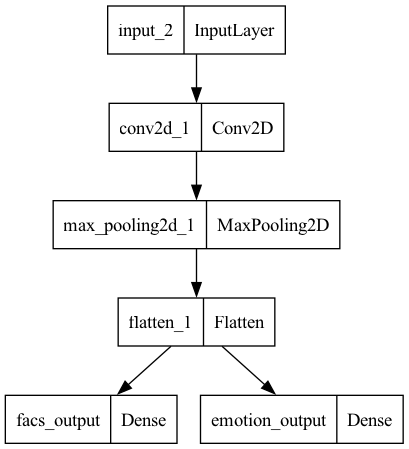

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 46, 46, 32)           320       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 32)           0         ['conv2d_1[0][0]']            
 g2D)                                                                                             
                                                                                                  
 flatten_1 (Flatten)         (None, 16928)                0         ['max_pooling2d_1[0][0]'

In [53]:
history = model.fit(X_train, {'facs_output': y_train_facs, 'emotion_output': y_train_emotion}, 
                    validation_data=(X_val, {'facs_output': y_val_facs, 'emotion_output': y_val_emotion}), 
                    epochs=100, batch_size=32)

# history = model.fit(train_generator, 
#                     validation_data=(X_val, {'facs_output': y_val_facs, 'emotion_output': y_val_emotion}), 
#                     epochs=100, batch_size=32)

Epoch 1/100


2023-11-15 21:03:51.512201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 1.5271 - facs_output_loss: 0.5150 - emotion_output_loss: 1.0121 - facs_output_accuracy: 0.2526 - emotion_output_accuracy: 0.5612

2023-11-15 21:03:56.525636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 7s 387ms/step - loss: 1.5271 - facs_output_loss: 0.5150 - emotion_output_loss: 1.0121 - facs_output_accuracy: 0.2526 - emotion_output_accuracy: 0.5612 - val_loss: 1.5579 - val_facs_output_loss: 0.4867 - val_emotion_output_loss: 1.0712 - val_facs_output_accuracy: 0.2857 - val_emotion_output_accuracy: 0.5833
Epoch 2/100
13/13 [==============================] - 1s 69ms/step - loss: 1.4457 - facs_output_loss: 0.4724 - emotion_output_loss: 0.9733 - facs_output_accuracy: 0.3214 - emotion_output_accuracy: 0.5893 - val_loss: 1.4541 - val_facs_output_loss: 0.4805 - val_emotion_output_loss: 0.9735 - val_facs_output_accuracy: 0.2024 - val_emotion_output_accuracy: 0.5833
Epoch 3/100
13/13 [==============================] - 1s 67ms/step - loss: 1.3917 - facs_output_loss: 0.4613 - emotion_output_loss: 0.9304 - facs_output_accuracy: 0.2908 - emotion_output_accuracy: 0.5918 - val_loss: 1.4560 - val_facs_output_loss: 0.4752 - val_emotion_output_loss: 0.9808 - va

In [54]:
# Evaluate the model on the test set
evaluation = model.evaluate(X_test, {'facs_output': y_test_facs, 'emotion_output': y_test_emotion})

# Unpacking the evaluation results
total_loss = evaluation[0] # Total loss
loss_facs = evaluation[1] # Loss for FACS output
loss_emotion = evaluation[2] # Loss for emotion output
accuracy_facs = evaluation[3] # Accuracy for FACS output
accuracy_emotion = evaluation[4] # Accuracy for emotion output

3/3 [==============================] - 0s 48ms/step - loss: 1.8240 - facs_output_loss: 0.6122 - emotion_output_loss: 1.2119 - facs_output_accuracy: 0.2381 - emotion_output_accuracy: 0.6310


In [55]:
predictions = model.predict(X_test)

1/3 [=========>....................] - ETA: 0s

2023-11-15 21:05:22.233756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 73ms/step


In [56]:
facs_predictions, emotion_predictions = predictions
# Processing FACS predictions: Convert probabilities to binary values
facs_pred_binary = (facs_predictions > 0.5).astype(int)

# Processing Emotion predictions: Convert probabilities to class labels
emotion_pred_labels = np.argmax(emotion_predictions, axis=1)

In [57]:
facs_pred_binary

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [58]:
emotion_pred_labels

array([1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 0, 1, 2, 0,
       0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 2])

## [6] HYPER TUNING

In [59]:
names = ['negative','positive','surprise']

def getLabel(id):
    return ['negative','positive','surprise'][id]

In [ ]:
# Tune note
    # Optimizer (Learning Rate, etc...)
    # Image Augumentation
    # Adjust Epoch
